# Simulation of arbitrary transfer functions

In some cases we can calculate the response of a system to an input completely analytically using Sympy as discussed in other notebooks. Sometimes these methods are not sufficient as they fail to calculate the inverse or because we have different inputs. This notebook covers several methods of simulating systems of arbitrary complexity.

In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

## Convert to ODE and integrate manually

We are very familiar with the Euler integration method by now. Let's recap a quick simulation of a first-order system

$$G = \frac{y(s)}{u(s)} = \frac{K}{\tau s + 1}$$

We can rewrite this in the time domain as

$$ y(s) (\tau s + 1) = K u(s) $$

$$ \tau \frac{dy}{dt} + y(t) = K u(t) $$

$$ \frac{dy}{dt} = -\frac{1}{\tau}y(t) + \frac{K}{\tau}u(t)$$

In [2]:
K = 1
tau = 5

This is our input function. Note that it could be anything (not just a step)

In [3]:
def u(t):
    if t<1:
        return 0
    else:
        return 1

In [4]:
ts = numpy.linspace(0, 20, 1000)
dt = ts[1]
y = 0
ys = []
for t in ts:
    dydt = -1/tau*y + 1/tau*u(t)
    
    y += dydt*dt
    ys.append(y)

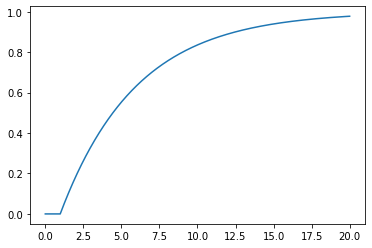

In [5]:
plt.plot(ts, ys)

## LTI support in scipy.signal

Notice in the previous code that all the differential equations were linear and that that none of the coefficients of the variables change over time. Such a system is known as a Linear, Time Invariant (LTI) system. The `scipy.signal` module supplies many functions for dealing with LTI systems

In [6]:
import scipy.signal

We define an LTI system by passing the coefficients of the numerator and denominator to the `lti` constructor

In [7]:
numerator = K
denominator = [tau, 1]
G = scipy.signal.lti(numerator, denominator)

In [8]:
G

TransferFunctionContinuous(
array([0.2]),
array([1. , 0.2]),
dt: None
)

In [9]:
type(G)

scipy.signal.ltisys.TransferFunctionContinuous

### Step responses

We can obtain the step response of the system by using the `step` method of the object

In [10]:
def plotstep(G):
    _, ys_step = G.step(T=ts)
    plt.plot(ts, ys_step);

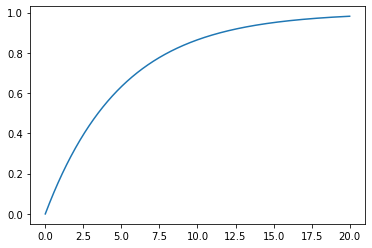

In [11]:
plotstep(G)

### Responses to arbitrary inputs

We can also find the response of the system to an arbitrary input signal by using `scipy.signal.lsim()`. This is useful when simulating a complicated response or a response to an input read from a file.

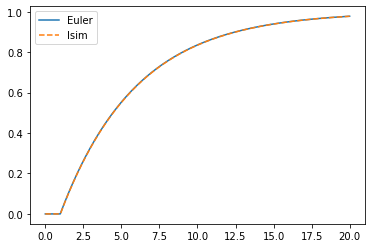

In [12]:
us = [u(t) for t in ts]  # evaluate the input function at all the times
_, ys_lsim, xs = scipy.signal.lsim(G, U=us, T=ts)
plt.plot(ts, ys)
plt.plot(ts, ys_lsim, '--');
plt.legend(['Euler', 'lsim'])

### Manual integration using state space form

We can also use our Euler loop to simulate arbitrary systems using the state space representation

\begin{align} 
    \dot{x} &= Ax + Bu \\ 
    y &= Cx + Du 
  \end{align}

This is a useful technique when simulating Hybrid systems (where some parts are LTI and some are nonlinear systems).

Luckily the `lti` object we created earlier can be converted to a state space representation.

In [13]:
Gss = G.to_ss()
Gss

StateSpaceContinuous(
array([[-0.2]]),
array([[1.]]),
array([[0.2]]),
array([[0.]]),
dt: None
)

In [14]:
x = numpy.zeros((Gss.A.shape[0], 1))
ys_statespace = []
for t in ts:
    xdot = Gss.A.dot(x) + Gss.B.dot(u(t))
    y = Gss.C.dot(x) +  Gss.D.dot(u(t))
    
    x += xdot*dt
    ys_statespace.append(y[0,0])

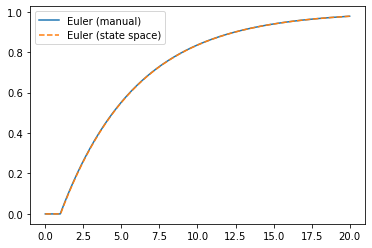

In [15]:
plt.plot(ts, ys)
plt.plot(ts, ys_statespace, '--')
plt.legend(['Euler (manual)', 'Euler (state space)'])

### Demonstration for higher order functions

As mentioned before, Sympy cannot always be used to obtain inverse Laplace transforms. The `scipy.signal` functions continue to work for higher order functions, too. Let's find the step response of the following transfer function:

$$G_2 = \frac{1}{s^3 + 2s^2 + s + 1}$$

Feel free to uncomment and run the block below: I gave up waiting for the inverse to be calculated.

In [16]:
# import sympy

# s, t = sympy.symbols('s, t')
# G2 = 1/(s**3 + 2*s**2 + s + 1)
# r = sympy.inverse_laplace_transform(G2/s, s, t)

However, the step response is calculated quickly by the LTI object.

In [17]:
numerator = 1
denominator = [1, 2, 1, 1]
G2 = scipy.signal.lti(numerator, denominator)

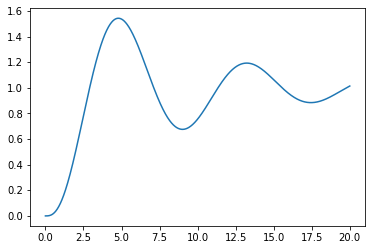

In [18]:
plotstep(G2)

### State space for higher order functions

In [19]:
Gss = G2.to_ss()

In [20]:
Gss

StateSpaceContinuous(
array([[-2., -1., -1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]]),
array([[1.],
       [0.],
       [0.]]),
array([[0., 0., 1.]]),
array([[0.]]),
dt: None
)

We can use the same code as before. Now, I'm going to store all the states as well. Notice that we have three states for the third order system.

In [21]:
x = numpy.zeros((Gss.A.shape[0], 1))
ys_statespace = []
xs = []
for t in ts:
    xdot = Gss.A.dot(x) + Gss.B.dot(u(t))
    y = Gss.C.dot(x) +  Gss.D.dot(u(t))
    
    x += xdot*dt
    ys_statespace.append(y[0, 0])
    # We need to copy otherwise the x update will overwrite all the values
    xs.append(x.copy()) 

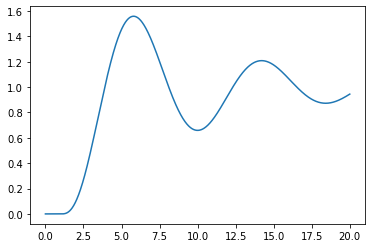

In [22]:
plt.plot(ts, ys_statespace)

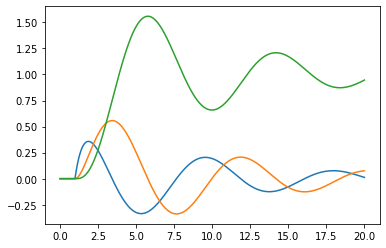

In [23]:
plt.plot(ts, numpy.concatenate(xs, axis=1).T)

### Systems in series

What if we wanted to see the response of $G_3(s) = G(s) G_2(s)$? You may expect that we would be able to find the product of two transfer functions, but the `scipy.signal` functions don't allow this.

In [24]:
G

TransferFunctionContinuous(
array([0.2]),
array([1. , 0.2]),
dt: None
)

In [25]:
# G*G2

# TypeError                                 Traceback (most recent call last)
# <ipython-input-25-2585f2f9cba1> in <module>()
# ----> 1 G*G2

# TypeError: unsupported operand type(s) for *: 'TransferFunctionContinuous' and 'TransferFunctionContinuous'

Instead, we could use the convolution of the numerators and the denominators. This is equivalent to polynomial multiplication. For instance, let's work out $(s + 1)^3$

In [26]:
numpy.convolve(numpy.convolve([1, 1], [1, 1]), [1, 1])

array([1, 3, 3, 1])

In [27]:
G.num

array([0.2])

In [28]:
numerator = numpy.convolve(G.num, G2.num)
numerator

array([0.2])

In [29]:
denominator = numpy.convolve(G.den, G2.den)
denominator

array([1. , 2.2, 1.4, 1.2, 0.2])

In [30]:
G3 = scipy.signal.lti(numerator, denominator)

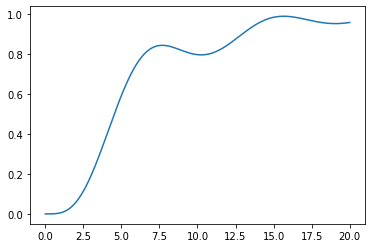

In [31]:
plotstep(G3)

## 3. Control module

Another option for handling LTI systems is to use the [Python Control Systems Libaray](https://python-control.readthedocs.io/en/latest/). Unfortunately, this is not included in anaconda, so you will have to install it before use by uncommenting the line below and running it:

In [32]:
#!pip install control

In [33]:
import control

A big benefit of this module is that its transfer function objects support arithmetic operations:

In [34]:
G = control.tf(K, [tau, 1])
G2 = control.tf(1, [1, 2, 1, 1])
G3 = G*G2

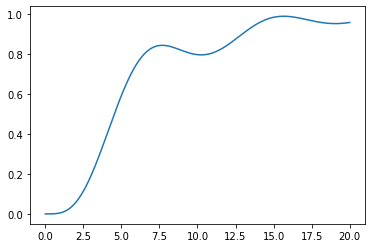

In [35]:
_, y = control.step_response(G3, ts)
plt.plot(ts, y)